# Model Creation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, mean_squared_error, classification_report
from sklearn.preprocessing import StandardScaler

In [3]:
sem1 = pd.read_csv('BMS_sem1_process.csv')
sem2 = pd.read_csv('BMS_sem1_process.csv')
merged = pd.merge(sem1, sem2, on='StudentId', suffixes=('_sem1', '_sem2'))

In [4]:
# Feature Engineering
# 1. Total Marks per Subject in Sem1
subjects_sem1 = ['BMSBC103', 'BMSBL107', 'BMSBS106', 'BMSECO102', 'BMSFA105', 'BMSFC104', 'BMSFHS101']
for subj in subjects_sem1:
    merged[f'Total_{subj}_sem1'] = merged[f'INT_{subj}_sem1'] + merged[f'EXT_{subj}_sem1']

# 2. Failure Flag for Sem1
merged['Failed_any_sem1'] = merged['Remark_sem1'].apply(lambda x: 1 if x == 'FAIL' else 0)

# 3. Aggregate Features
features = [
    'SGPA_sem1', 'Percentage_sem1', 'Failed_any_sem1',
    'Total_BMSBC103_sem1', 'Total_BMSBL107_sem1', 'Total_BMSBS106_sem1',
    'Total_BMSECO102_sem1', 'Total_BMSFA105_sem1', 'Total_BMSFC104_sem1',
    'Total_BMSFHS101_sem1'
]

In [5]:
# Define Target (Predict Sem2 Outcome)

# Option 1: Classification (PASS/FAIL)
merged['Target_Remark'] = merged['Remark_sem2'].apply(lambda x: 1 if x == 'PASS' else 0)

# Option 2: Regression (SGPA_sem2)
target_sgpa = merged['SGPA_sem2']

X = merged[features]
y = merged['Target_Remark']

In [6]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [8]:
# Model 1: Random Forest Classifier (PASS/FAIL)
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_scaled, y_train)
y_pred = clf.predict(X_test_scaled)
print("Classification Results:")
print("Accuracy:", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Classification Results:
Accuracy: 1.0
              precision    recall  f1-score   support

           1       1.00      1.00      1.00        29

    accuracy                           1.00        29
   macro avg       1.00      1.00      1.00        29
weighted avg       1.00      1.00      1.00        29



In [9]:
# Cross-Validation
cv_scores = cross_val_score(clf, X, y, cv=5)
print("Cross-Validation Accuracy:", np.mean(cv_scores))

Cross-Validation Accuracy: 0.9928571428571429


In [10]:
# Model 2: Linear Regression (SGPA Prediction)
X_train_sgpa, X_test_sgpa, y_train_sgpa, y_test_sgpa = train_test_split(X, target_sgpa, test_size=0.2, random_state=42)
reg = LinearRegression()
reg.fit(X_train_sgpa, y_train_sgpa)
y_pred_sgpa = reg.predict(X_test_sgpa)

print("\nRegression Results:")
print("RMSE:", mean_squared_error(y_test_sgpa, y_pred_sgpa, squared=False))
print("R² Score:", reg.score(X_test_sgpa, y_test_sgpa))


Regression Results:
RMSE: 2.7499425175900858e-15
R² Score: 1.0


c:\Users\suraj\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


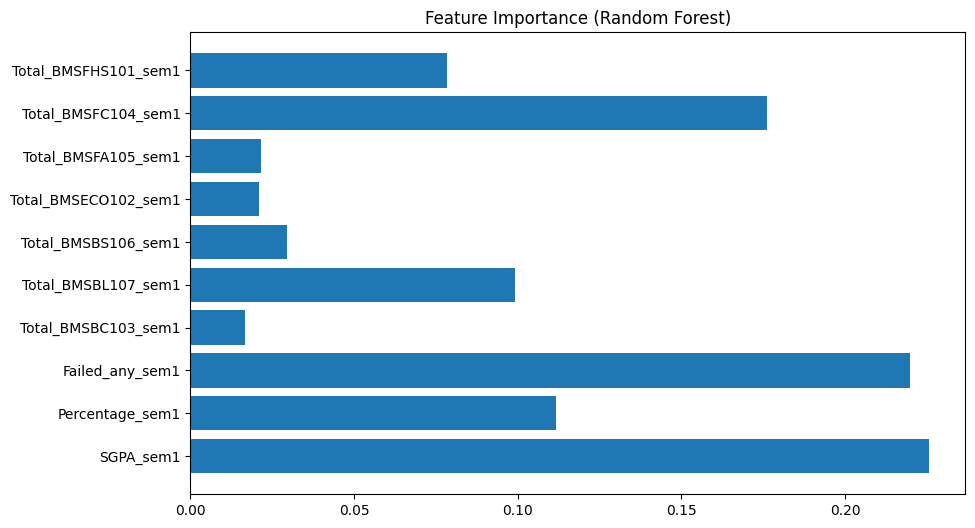

In [11]:
# Feature Importance (Classification)
plt.figure(figsize=(10, 6))
plt.barh(features, clf.feature_importances_)
plt.title("Feature Importance (Random Forest)")
plt.show()

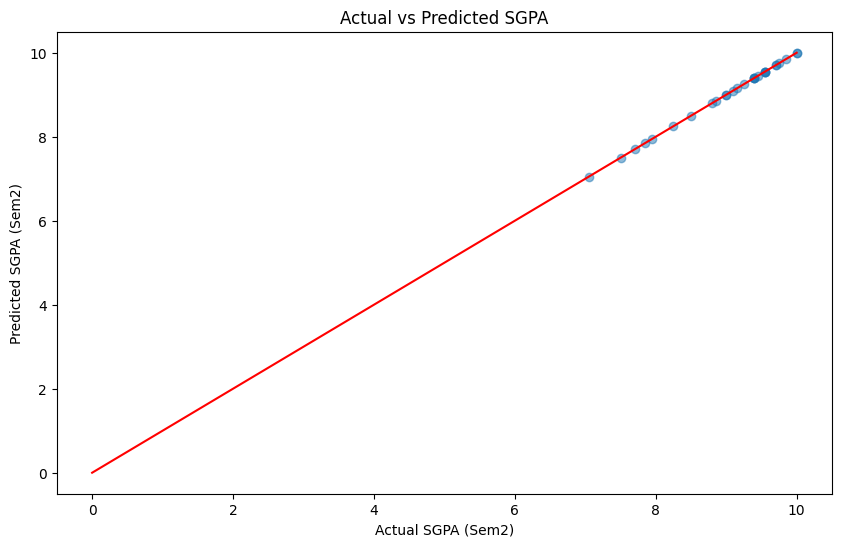

In [12]:
# Scatter Plot for Regression Predictions
plt.figure(figsize=(10, 6))
plt.scatter(y_test_sgpa, y_pred_sgpa, alpha=0.5)
plt.xlabel("Actual SGPA (Sem2)")
plt.ylabel("Predicted SGPA (Sem2)")
plt.title("Actual vs Predicted SGPA")
plt.plot([0, 10], [0, 10], color='red')
plt.show()

In [13]:
import pandas as pd
import numpy as np
import pymongo
from pymongo import MongoClient
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Function to connect to MongoDB and fetch data
def get_data_from_mongodb():
    try:
        # Connect to MongoDB
        client = MongoClient("mongodb://localhost:27017/")
        db = client["student_process_db"]
        
        # Get data from both semesters
        sem1_data = list(db.sem1.find())
        sem2_data = list(db.sem2.find())
        
        # Convert to pandas DataFrames
        sem1_df = pd.DataFrame(sem1_data)
        sem2_df = pd.DataFrame(sem2_data)
        
        print(f"Retrieved {len(sem1_df)} records from Semester 1 and {len(sem2_df)} records from Semester 2")
        
        return sem1_df, sem2_df
    
    except Exception as e:
        print(f"Error connecting to MongoDB: {e}")
        return None, None

# Function to preprocess data
def preprocess_data(sem1_df, sem2_df):
    # Merge datasets on StudentId
    merged_df = pd.merge(sem1_df, sem2_df, on='StudentId', suffixes=('_sem1', '_sem2'))
    
    # Drop MongoDB ObjectId columns
    merged_df = merged_df.drop(['_id_sem1', '_id_sem2'], axis=1, errors='ignore')
    
    # Extract features from semester 1 data
    features = merged_df.filter(regex='^INT_.*_sem1$|^EXT_.*_sem1$|TotalMarksObtained_sem1|Percentage_sem1|SGPA_sem1')
    
    # Target variables from semester 2
    targets = {
        'SGPA': merged_df['SGPA_sem2'],
        'Percentage': merged_df['Percentage_sem2'],
        'TotalMarksObtained': merged_df['TotalMarksObtained_sem2']
    }
    
    # Student IDs for reference
    student_ids = merged_df['StudentId']
    
    return features, targets, student_ids, merged_df

# Function to train the model
def train_model(features, targets):
    models = {}
    
    for target_name, target_values in targets.items():
        # Split the data
        X_train, X_test, y_train, y_test = train_test_split(features, target_values, test_size=0.2, random_state=42)
        
        # Create and train the model
        model = RandomForestRegressor(n_estimators=100, random_state=42)
        model.fit(X_train, y_train)
        
        # Evaluate the model
        y_pred = model.predict(X_test)
        mse = mean_squared_error(y_test, y_pred)
        r2 = r2_score(y_test, y_pred)
        
        print(f"{target_name} - MSE: {mse:.4f}, R² Score: {r2:.4f}")
        
        # Store model and metrics
        models[target_name] = {
            'model': model,
            'mse': mse,
            'r2': r2,
            'feature_importance': model.feature_importances_
        }
    
    return models

# Function to save models
def save_models(models):
    if not os.path.exists('models'):
        os.makedirs('models')
    
    for target_name, model_data in models.items():
        with open(f'models/{target_name}_model.pkl', 'wb') as f:
            pickle.dump(model_data['model'], f)
    
    print("Models saved successfully")

# Function to load models
def load_models():
    models = {}
    for target_name in ['SGPA', 'Percentage', 'TotalMarksObtained']:
        try:
            with open(f'models/{target_name}_model.pkl', 'rb') as f:
                models[target_name] = pickle.load(f)
        except FileNotFoundError:
            print(f"Model for {target_name} not found. Please train the model first.")
    return models

# Function to predict performance for a student
def predict_student_performance(student_id, sem1_df, models):
    # Get student data from semester 1
    student_data = sem1_df[sem1_df['StudentId'] == student_id]
    
    if student_data.empty:
        print(f"Student with ID {student_id} not found in semester 1 data")
        return None
    
    # Prepare features
    features = student_data.filter(regex='^INT_.*|^EXT_.*|TotalMarksObtained|Percentage|SGPA')
    
    # Make predictions
    predictions = {}
    for target_name, model in models.items():
        prediction = model.predict(features)[0]
        predictions[target_name] = prediction
    
    return predictions, student_data

# Function to analyze student performance
def analyze_performance(student_id, sem1_df, sem2_df=None):
    # Load models
    models = load_models()
    
    if not models:
        print("No trained models found. Training models first...")
        features, targets, _, _ = preprocess_data(sem1_df, sem2_df)
        models = train_model(features, targets)
        save_models(models)
        
    # Make prediction
    result = predict_student_performance(student_id, sem1_df, models)
    
    if result is None:
        return
    
    predictions, student_data = result
    
    # Display student info
    print("\n----- Student Information (Semester 1) -----")
    print(f"Student ID: {student_id}")
    print(f"Semester 1 SGPA: {student_data['SGPA'].values[0]:.2f}")
    print(f"Semester 1 Percentage: {student_data['Percentage'].values[0]:.2f}%")
    print(f"Semester 1 Total Marks: {student_data['TotalMarksObtained'].values[0]:.2f}")
    
    # Display predictions
    print("\n----- Predicted Performance for Semester 2 -----")
    print(f"Predicted SGPA: {predictions['SGPA']:.2f}")
    print(f"Predicted Percentage: {predictions['Percentage']:.2f}%")
    print(f"Predicted Total Marks: {predictions['TotalMarksObtained']:.2f}")
    
    # Compare SGPA
    sgpa_diff = predictions['SGPA'] - student_data['SGPA'].values[0]
    print("\n----- Performance Analysis -----")
    if sgpa_diff > 0.5:
        print(f"Expected improvement in SGPA by {sgpa_diff:.2f} points")
    elif sgpa_diff < -0.5:
        print(f"Expected decrease in SGPA by {abs(sgpa_diff):.2f} points. Consider additional support.")
    else:
        print("SGPA is expected to remain relatively stable")
    
    # Check actual semester 2 data if available
    if sem2_df is not None:
        actual_data = sem2_df[sem2_df['StudentId'] == student_id]
        if not actual_data.empty:
            print("\n----- Actual vs Predicted (Semester 2) -----")
            print(f"Actual SGPA: {actual_data['SGPA'].values[0]:.2f} | Predicted: {predictions['SGPA']:.2f}")
            print(f"Actual Percentage: {actual_data['Percentage'].values[0]:.2f}% | Predicted: {predictions['Percentage']:.2f}%")
            print(f"Actual Total Marks: {actual_data['TotalMarksObtained'].values[0]:.2f} | Predicted: {predictions['TotalMarksObtained']:.2f}")
    
    # Analyze subject performance
    print("\n----- Subject-wise Performance Analysis from Semester 1 -----")
    subject_cols = [col for col in student_data.columns if col.startswith('INT_') or col.startswith('EXT_')]
    subject_data = []
    
    for i in range(0, len(subject_cols), 2):
        if i+1 < len(subject_cols):
            int_col = subject_cols[i]
            ext_col = subject_cols[i+1]
            subject_code = int_col.replace('INT_', '')
            
            int_marks = student_data[int_col].values[0]
            ext_marks = student_data[ext_col].values[0]
            total_marks = int_marks + ext_marks
            
            subject_data.append({
                'Subject': subject_code,
                'Internal': int_marks,
                'External': ext_marks,
                'Total': total_marks
            })
    
    subject_df = pd.DataFrame(subject_data)
    print(subject_df.to_string(index=False))
    
    # Identify strengths and weaknesses
    if not subject_df.empty:
        best_subject = subject_df.loc[subject_df['Total'].idxmax()]
        worst_subject = subject_df.loc[subject_df['Total'].idxmin()]
        
        print(f"\nStrongest subject: {best_subject['Subject']} with a total of {best_subject['Total']} marks")
        print(f"Subject needing improvement: {worst_subject['Subject']} with a total of {worst_subject['Total']} marks")
    
    return predictions, student_data

# Visualize the most important features
def visualize_feature_importance(sem1_df, sem2_df):
    # Preprocess data
    features, targets, _, _ = preprocess_data(sem1_df, sem2_df)
    
    # Train model
    models = train_model(features, targets)
    
    # Plot feature importance for SGPA prediction
    print("\nVisualizing feature importance for SGPA prediction...")
    feature_importance = pd.DataFrame({
        'Feature': features.columns,
        'Importance': models['SGPA']['feature_importance']
    }).sort_values('Importance', ascending=False)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(x='Importance', y='Feature', data=feature_importance.head(10))
    plt.title('Top 10 Features for SGPA Prediction')
    plt.tight_layout()
    plt.savefig('feature_importance.png')
    print("Feature importance visualization saved as 'feature_importance.png'")

# Main function
def main():
    # Get command line arguments
    import sys
    
    if len(sys.argv) < 2:
        print("Usage: python predict.py [train|predict|analyze] [student_id]")
        return
    
    command = sys.argv[1]
    
    # Get data from MongoDB
    sem1_df, sem2_df = get_data_from_mongodb()
    
    if sem1_df is None or sem2_df is None:
        print("Could not retrieve data from MongoDB")
        return
    
    if command == 'train':
        print("Training models...")
        features, targets, _, _ = preprocess_data(sem1_df, sem2_df)
        models = train_model(features, targets)
        save_models(models)
        visualize_feature_importance(sem1_df, sem2_df)
        
    elif command == 'predict' or command == 'analyze':
        if len(sys.argv) < 3:
            print(f"Please provide a student ID: python predict.py {command} [student_id]")
            return
        
        student_id = int(sys.argv[2])
        analyze_performance(student_id, sem1_df, sem2_df)
    
    else:
        print("Unknown command. Use 'train', 'predict', or 'analyze'")

if __name__ == "__main__":
    main()

Retrieved 142 records from Semester 1 and 142 records from Semester 2
Unknown command. Use 'train', 'predict', or 'analyze'
